In [2]:
import os
import zipfile

# Path to the ZIP file and dataset folder
zip_path = r"D:\brain_tumor_data\brain_tumor_data.zip"
dataset_path = r"D:\brain_tumor_data"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Print paths
print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")


Training Directory: D:\brain_tumor_data\Training
Testing Directory: D:\brain_tumor_data\Testing


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Preprocessing and Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill any missing pixels
)

# For validation, only rescale the images
valid_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the data (categorical classification)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Use categorical for multiple categories
    classes=categories,  # Ensure correct class order
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    shuffle=False  # Don't shuffle for evaluation purposes
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the CNN Model for multi-class classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output layer (4 categories)
])

# Compile the model for multi-class classification
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Update the model checkpoint path to end with .keras
model_checkpoint = ModelCheckpoint('brain_tumor_detection_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.4713 - loss: 1.1550 - val_accuracy: 0.5072 - val_loss: 1.4677
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6762 - loss: 0.7952 - val_accuracy: 0.6262 - val_loss: 0.9789
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6809 - loss: 0.7552 - val_accuracy: 0.7468 - val_loss: 0.6965
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.7459 - loss: 0.6333 - val_accuracy: 0.5706 - val_loss: 1.2519
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7582 - loss: 0.6207 - val_accuracy: 0.7079 - val_loss: 0.7789
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7929 - loss: 0.5408 - val_accuracy: 0.7300 - val_loss: 0.8012
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.7972 - loss: 0.5096 - val_accuracy: 0.7872 - val_loss: 0.5111
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.8138 - loss: 0.4798 - val_accuracy: 0.704

In [6]:
# Load the best saved model
from tensorflow.keras.models import load_model
model = load_model('brain_tumor_detection_model.h5')

# Evaluate the model on test data
loss, accuracy = model.evaluate(valid_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.7824 - loss: 0.6394
Test Loss: 0.6541418433189392
Test Accuracy: 0.7795575857162476


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.67      0.80       300
  meningioma       0.67      0.82      0.74       306
     notumor       0.72      0.99      0.84       405
   pituitary       0.94      0.56      0.71       300

    accuracy                           0.78      1311
   macro avg       0.83      0.76      0.77      1311
weighted avg       0.82      0.78      0.77      1311

Confusion Matrix:
 [[201  89   3   7]
 [  1 252  50   3]
 [  0   5 400   0]
 [  0  32  99 169]]


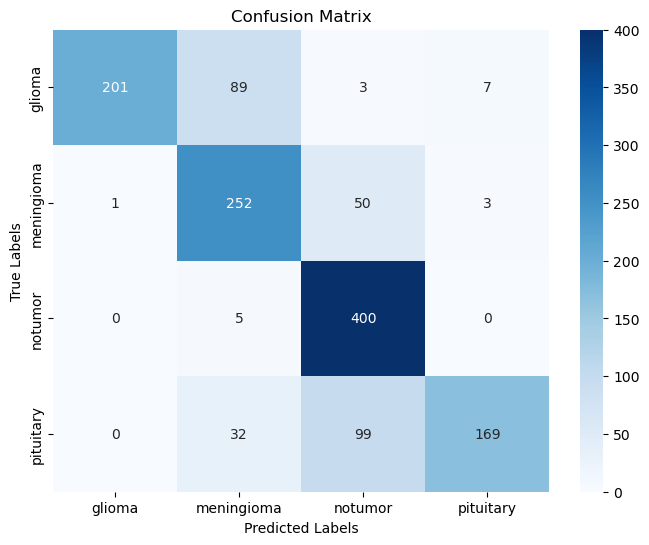

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the test data
predictions = model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoding to class labels

# Get true labels
true_labels = valid_generator.classes

# Classification Report and Confusion Matrix
report = classification_report(true_labels, predicted_classes, target_names=categories)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [9]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 38.8/38.8 MB 901.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


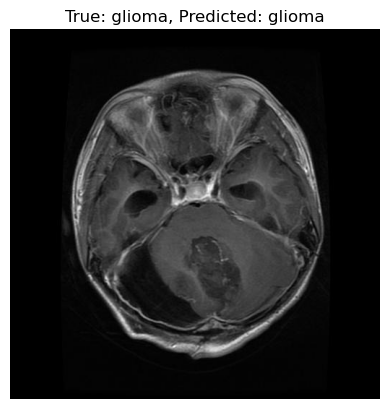

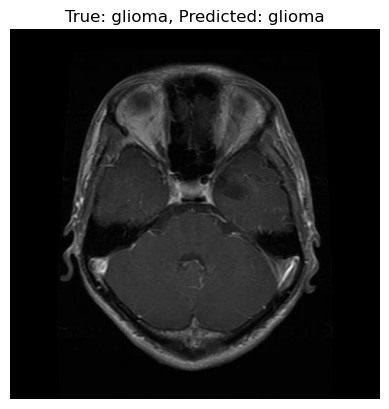

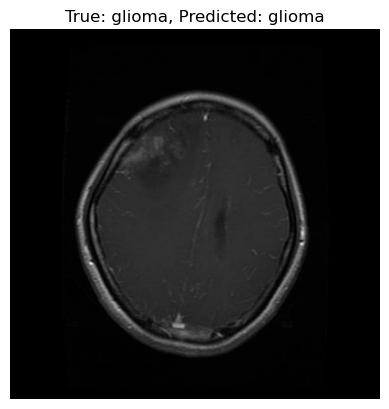

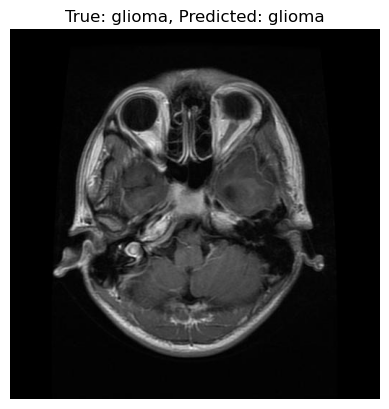

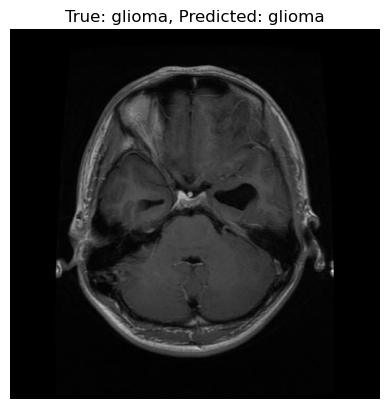

In [8]:
# Function to display image with prediction
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt  # Ensure you import matplotlib for plt

def display_image_with_prediction(img_path, true_label, predicted_class):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Visualize predictions on the first few test images
for i in range(5):  # Adjust as needed
    img_path = os.path.join(test_dir, valid_generator.filenames[i])
    true_label = categories[true_labels[i]]  # Ensure true_labels and predicted_classes are defined
    predicted_class = categories[predicted_classes[i]]
    display_image_with_prediction(img_path, true_label, predicted_class)


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step


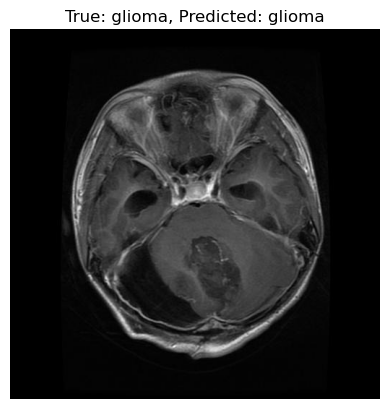

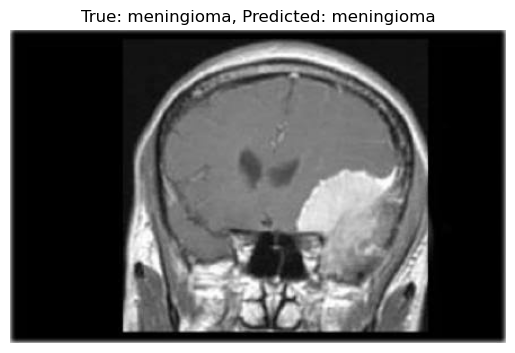

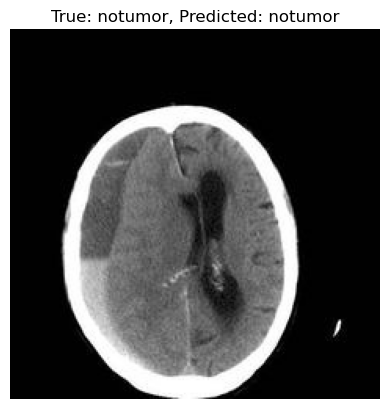

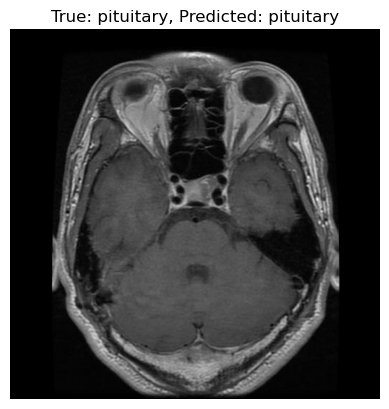

In [13]:
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def display_image_with_prediction(img_path, true_label, predicted_class):
    """
    Display an image with its true label and predicted class.
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Get predictions for the test set
predictions = model.predict(valid_generator)  # Predict probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_labels = valid_generator.classes  # True class indices
filenames = valid_generator.filenames  # List of file paths in the test set

# Define the categories (ensure this matches your dataset setup)
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# Dictionary to store the first instance of each category
category_images = {}

# Loop through the test dataset
for i in range(len(filenames)):
    true_label_index = true_labels[i]
    true_label = categories[true_label_index]
    
    # Check if we already have an image for this category
    if true_label not in category_images:
        img_path = os.path.join(test_dir, filenames[i])  # Full path to the image
        predicted_class = categories[predicted_classes[i]]  # Predicted class label
        category_images[true_label] = (img_path, true_label, predicted_class)

    # Stop when we have at least one image for each category
    if len(category_images) == len(categories):
        break

# Display the selected images with predictions
for true_label, (img_path, true_label, predicted_class) in category_images.items():
    display_image_with_prediction(img_path, true_label, predicted_class)


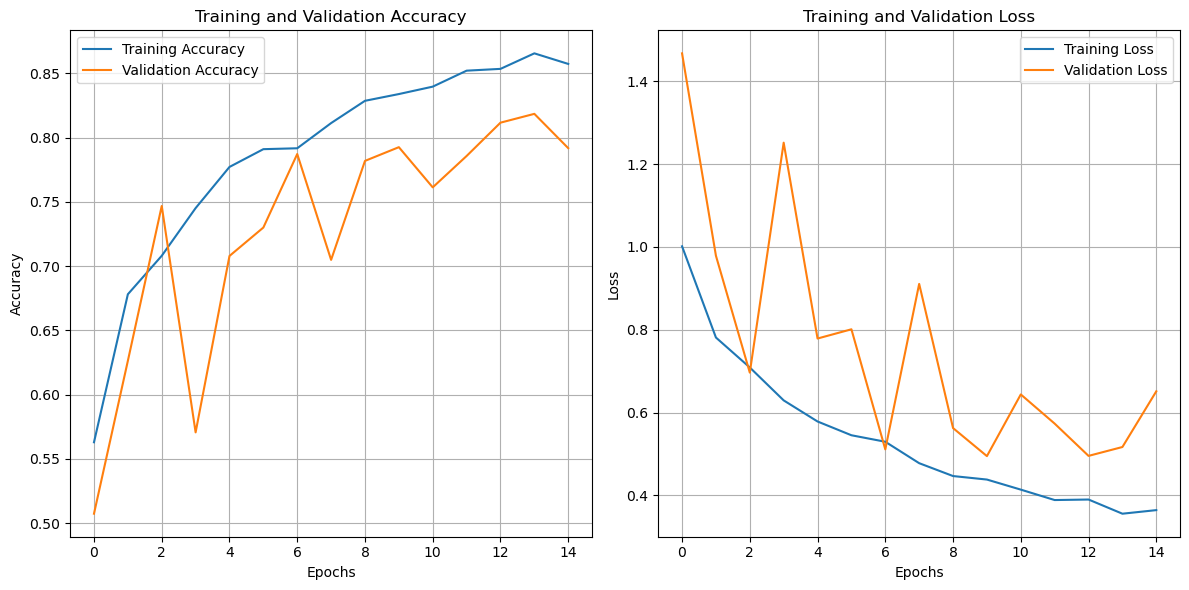

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss curves.
    """
    # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)
